# Imports

In [1]:
#General
import re
import os
import math
import random
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

#XML parsing
from xml.etree import ElementTree

#Model
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import FeatureUnion

#Testing
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

#NLTK
import nltk
from nltk import TweetTokenizer
from nltk.corpus import wordnet
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

# Functions 


In [2]:

################################## Global Values #############################################################
#--- init OneHotEncoders
ohe = OneHotEncoder(sparse = True) 
ohe_FW = OneHotEncoder(sparse = True)
ohe_Cap = OneHotEncoder(sparse = True)
#--- init stemmer
porter_stemmer=PorterStemmer()

################################### General functions  #######################################################
def word_tokenize(X):
    tt = TweetTokenizer()
    return tt.tokenize(X)
    
def to_Matrix (X):
    return [X]

def getAllUnique(X):
    UniqueList = []
    tmpList = X["Text"].tolist()
    for utt in tmpList:
        placeholders = (word_tokenize(utt))
        for cleaned in placeholders:
            UniqueList.append(cleaned)
    return set(UniqueList)
    
    # -----------------Re-sampling function ---------------#
    # Rob van der Goot, Ahmet ̈Ust ̈un, Alan Ramponi, and Barbara Plank. 2020a. MaChAmp proportional sam-pling. 
    # https://github.com/machamp-nlp/machamp/blob/master/machamp/modules/bucket_batch_sampler.py

def sample_smoothing(dataframe, sampling_smoothing):

    distribution = dataframe.groupby(dataframe['Label']).count()['Text']
    labels = dataframe['Label'].unique().tolist()
    labels.sort()

    if sampling_smoothing != 1.0:
        all_batches = []
        df_sorted = dataframe.sort_values(by='Label')

        for label in labels:
            df_Batch = df_sorted[df_sorted['Label'] == label]
            batch = df_Batch.values.tolist()
            all_batches.append(batch)


        sizes = distribution.tolist()
        total_size = sum(sizes)

        # calculate new size based on smoothing
        new_sizes = []
        total_new_prob = 0.0
        for size in sizes:
            pi = size/total_size
            total_new_prob += math.pow(pi, sampling_smoothing)

        for size in sizes:
            pi = size/total_size
            prob = (1/pi) * (math.pow(pi, sampling_smoothing)/total_new_prob)
            new_sizes.append(int(size * prob))
        # print(new_sizes)

        # collect all batches
        this_epoch_all_batches = []
        for dataset_idx in range(len(sizes)):
            new_size = new_sizes[dataset_idx]
            while new_size > len(all_batches[dataset_idx]):
                all_batches[dataset_idx] += all_batches[dataset_idx]
            this_epoch_all_batches += all_batches[dataset_idx][:new_size]

        # shuffle all batches
        random.seed(1)
        random.shuffle(this_epoch_all_batches)
        # recreate dataframe
        return pd.DataFrame(this_epoch_all_batches, columns=['Text', 'Label'])

    else: 
        return dataframe


################################## for CountVectorizer #######################################################

#---Tokenizer for CountVectorizer
def custom_tokenizer(document):
    tknzr = TweetTokenizer()
    tokens = tknzr.tokenize(document)
    return tokens


#---Pre Processorfor CountVectorizer
def custom_Preproccesing(text):
    # text = re.sub('(\S*User\S*)','_User_', text) # generalize usernames// comment in for username generalization
    words=re.split("\\s+",text)
    stemmed_words=[porter_stemmer.stem(word=word) for word in words]

    return ' '.join(stemmed_words)


################################## for Custom Featurizers ####################################################
#Featurizer 1 
class FeaturizerLength(TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        utt_List = X.tolist()
        d = []
        bins = np.arange(1, 170, 5).tolist()
        bin_name = np.arange(1,35,1).tolist()
        for utt in utt_List:
            utt_len = len(utt)
            if utt_len > 170:
                placeholder = 35
            else:
                placeholder = (np.digitize(utt_len,bins=bins, right=False)).tolist()
            d.append(to_Matrix(placeholder))
        return ohe.fit_transform(d)
     


    def get_feature_names(self):
        return ohe.categories_


#Featurizer 2 
class FeaturizerFirstWord(TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        cont_Words = {"and","but" , "or", "while", "me", "also", "hence", "thus", "so", "because"}
        utt_List = X.tolist()
        fwList = []
        for utt in utt_List:
            if " " in utt:
                placeholder = utt.split(" ")[0].lower()
                if placeholder in cont_Words:
                    fwList.append(to_Matrix(1))
                else:
                    fwList.append(to_Matrix(0))
            else:
                if utt.lower() in cont_Words:
                    fwList.append(to_Matrix(1))
                else:
                    fwList.append(to_Matrix(0))
        return ohe_FW.fit_transform(fwList)

    def get_feature_names(self):
        return ohe_FW.categories_

# Parsers
## CSV "Parser" for ConvitKit Annotated Corpus

In [3]:
df_Reddit = pd.read_csv("../RedditConviKit/RedditCorpusAnnotated.csv")        
df_Reddit.dropna(axis=0, subset=['Label'], how='all', inplace=True)
df_Reddit = df_Reddit[df_Reddit['Label'] != 'System']
df_Reddit

,id,timestamp,speaker,reply_to,conversation_id,meta.top_level_comment,meta.subreddit,utt_length,Text,MlviLabel,NikwLabel,Label
0,e631679,1537119633,MooMoo4228,9gb412,9gb412,e631679,todayilearned,127,Owen Wilson is usually known for comedies but ...,Statement,Statement,Statement
1,e632xlh,1537121043,poopiepuppy,e631679,9gb412,e631679,todayilearned,18,Such a great film!,Emphasis,Accept,Emphasis
2,e634v7o,1537122592,dr-cringe,e631679,9gb412,e631679,todayilearned,97,I saw him in Shanghai Noon before BEL. I could...,Statement,Emphasis,Emphasis
3,e635506,1537122816,belugabagel,e631679,9gb412,e631679,todayilearned,142,It's up there with Taken for me as a movie whe...,Statement,Statement,Statement
4,e635ue5,1537123387,SpaceJuke,e631679,9gb412,e631679,todayilearned,22,Also Midnight in Paris,Continuer,Statement,Continuer
...,...,...,...,...,...,...,...,...,...,...,...,...
995,e67r1vs,1537302212,Ralph-Hinkley,e67qipy,9gvc97,e6715gk,trees,85,DC has lots of shady places like that. Buy *so...,Statement,Statement,Statement
996,e67r6sh,1537302320,Ralph-Hinkley,e67p8d7,9gvc97,e6715gk,trees,150,Correct. Been decriminalized in Ohio for years...,Accept,Accept,Accept
997,e67rco0,1537302448,kgonzales90,e67r6sh,9gvc97,e6715gk,trees,102,Im in Texas and its decriminalized but it depe...,Statement,Statement,Statement
998,e67rrv5,1537302786,jackster_,e67qipy,9gvc97,e6715gk,trees,63,"My weed is free, it just comes in a very expen...",Statement,Statement,Statement



## XML Parser for NPSCHATCORPUS
Custom build XML parser, created for loading the NPSCHATCORPUS.

In [4]:
#Initialize Dataframe
df_NPSPre = pd.DataFrame(columns = ["Text", "Label"])

#XML Parser for NPSCHAT CORPUS
folder_path = "../npsChat/XML Files"
XML_files = os.listdir(folder_path)
for f in XML_files:
    file_name = "../npsChat/XML Files/" + f
    Tree = ElementTree.parse(file_name)
    session = Tree.getroot()
    for Posts in session:
        for post in Posts:
            Utt_Class = (post.attrib["class"])
            Utt_text = post.text
            new_Row = {"Text": Utt_text, "Label": Utt_Class}
            df_NPSPre = df_NPSPre.append(new_Row, ignore_index = True)

# Cross domain specific Pre-processing for SVM

In [5]:
# Removing system label
df_NPSPre = df_NPSPre[df_NPSPre['Label'] != 'System']
df_NPSPre.reset_index(drop = True, inplace = True)

# Re sampleling
df_NPS = sample_smoothing(df_NPSPre, 0.5)    # Change to any value between 1.0 and 0.0
df_NPS["Label"].value_counts()

#Create stop-words list for CountVectorizer // Provides no positive benefit so far
UniqueReddit = list(getAllUnique(df_Reddit))
UniqueNPS = list(getAllUnique(df_NPS))
custom_Stop_words = (np.setdiff1d(UniqueNPS,UniqueReddit, assume_unique=True)).tolist()    # Assume_unique set to true, since we've allready create a set-list of input words

## Creating a xlsx file for Wordify
https://wordify.unibocconi.it/index

In [6]:
# # Comment in if you need to create the file
# df_NPSPre["Text"] = df_NPSPre["Text"].apply(lambda x: custom_Preproccesing(x))
# df_NPSPre.to_excel("Towordify.xlsx") 

# Model Setup

## Vectorization

In [7]:
X = df_NPS['Text']
y = df_NPS['Label']

reddit_vocab = df_Reddit['Text']
reddit_label = df_Reddit['Label']

reddit_dev, reddit_test, reddit_dev_label, reddit_test_Labels = train_test_split(reddit_vocab, reddit_label, train_size=0.50, test_size=0.50, random_state =101)

In [8]:
FU = FeatureUnion([
    ("CountVecWord",CountVectorizer(preprocessor=custom_Preproccesing, tokenizer=custom_tokenizer, ngram_range=(1,1), binary = False)),
    ("VecLen",FeaturizerLength()),
    ("VecFirstWord", FeaturizerFirstWord()),
])

FU.fit_transform(X)

X_vectorized = FU.transform(X)
reddit_vectorized = FU.transform(reddit_dev)
print(X_vectorized.shape)
print(reddit_vectorized.shape)


(7705, 3885)
(496, 3885)


## Support Vector Machine

Accuracy (RBF Kernel):  64.11
F1 (RBF Kernel):  61.15


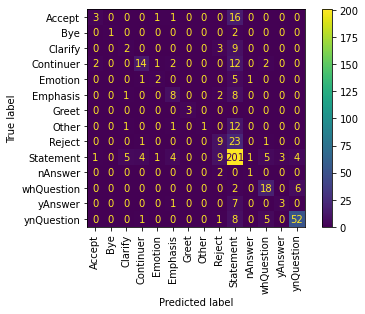

In [9]:
rbf_reddit = svm.SVC(kernel='rbf', gamma=0.01, C=11).fit(X_vectorized, y)
rbf_reddit_pred = rbf_reddit.predict(reddit_vectorized) 
rbf_reddit_accuracy = accuracy_score(reddit_dev_label, rbf_reddit_pred)
rbf_reddit_f1 = f1_score(reddit_dev_label, rbf_reddit_pred, average = 'weighted')
print('Accuracy (RBF Kernel): ', "%.2f" % (rbf_reddit_accuracy*100))
print('F1 (RBF Kernel): ', "%.2f" % (rbf_reddit_f1*100))
plot_confusion_matrix(rbf_reddit, reddit_vectorized, reddit_dev_label, xticks_rotation = 'vertical')  
plt.show()



# Cross validation 

In [10]:
# grid_param = [
#     {
#     'C': [9,10,11,12,13,14],
#     'gamma': ['scale', 0.1, 0.05, 0.03, 0.01, 0.008, 0.005],
#     'kernel': ['rbf']}, 
# ]

# optimal_params = GridSearchCV(
#     svm.SVC(),
#     grid_param,
#     cv = 5,
#     scoring = 'accuracy',
#     verbose = 0)

# optimal_params.fit(X_vectorized, y)
# print(optimal_params.best_score_)
# print(optimal_params.best_params_)

# Final Test set Validation

In [11]:
redditTest_vectorized = FU.transform(reddit_test)
print(redditTest_vectorized.shape)
rbfTest_reddit = svm.SVC(kernel='rbf', gamma=0.01, C=11).fit(X_vectorized, y)
rbf_redditTest_pred = rbfTest_reddit.predict(redditTest_vectorized)
rbf_redditTest_accuracy = accuracy_score(reddit_test_Labels, rbf_redditTest_pred)
rbf_redditTest_f1 = f1_score(reddit_test_Labels, rbf_redditTest_pred, average = 'weighted')
print('Accuracy (RBF Kernel): ', "%.2f" % (rbf_redditTest_accuracy*100))
print('F1 (RBF Kernel): ', "%.2f" % (rbf_redditTest_f1*100))

(497, 3885)
Accuracy (RBF Kernel):  58.75
F1 (RBF Kernel):  55.21
